# 1. VK Social network analysis


## 1.1 Download your vk friends information 

1. You need to get access token, go here https://vk.com/dev and create stand alone application
    - Мои приложения
    - Создать приложение
    - Standalone


2. Access token можно найти в разделе Настройки вашего приложения, вам нужен тот который `Сервисный ключ доступа`

3. Список методов API https://vk.com/dev/methods
4. Нам потребуются методы `friends.get` и `users.get`

In [202]:
import json
import requests
import pandas as pd
from tqdm.notebook import tqdm
import networkx as nx
from igraph import Graph, ADJ_MAX
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

In [3]:
def get_friends_info(user_id, access_token, fields=None):
    if fields is None:
        fields = 'sex'
    api = 'https://api.vk.com/method/'
    friends_url = f'{api}friends.get?fields={fields}&user_id={user_id}&access_token={access_token}&v=5.131'
    json_response = requests.get(friends_url).json()
    if json_response.get('error'):
        return False
        # raise KeyError(f'Inable to access {user_id} friends.')

    return json_response[u'response'], friends_url

In [29]:
user_id = ''
fields = 'sex,city,education,bdate' # check https://vk.com/dev/users.get for all possible fields values
access_token = '' # put your token


my_mates, url = get_friends_info(user_id, access_token, fields)

In [40]:
my_mates['count']

74

In [31]:
len(my_mates['items'])

74

In [33]:
friend_ids = [mate['id'] for mate in my_mates['items']]

In [27]:
# парсинг друзей друзей
friends_mates_dict = {"id": [], "mates": []}
for friend_id in tqdm(friend_ids):
    result = get_friends_info(friend_id, access_token, fields)
    if result == False:
        pass
    else:
        mates = result[0]
        friends_mates_dict["id"].append(friend_id)
        friends_mates_dict["mates"].append(mates)

  0%|          | 0/74 [00:00<?, ?it/s]

# Сохраните две таблички: Информация о пользователях, список ребер

Хранить такой граф удобно ввиде списка ребер, то есть таблицы с двумя колонками:

| Вершина 1 | Вершина 2 |
|---|---|
|user_id_1| user_id_2|
|user_id_1| user_id_3|
|user_id_2| user_id_3|

Информацию о пользователях удобно хранить в отдельной таблице:

| User id | Name | Sex | Birthday |
|---|---|---|---|
|user_id_1| Anastasia | Female | 01.02.2003 |
|user_id_2| Alex |Male| 21.01.1999|
|user_id_3| Yulia|Female| 06.05.2001|

В качестве решения пришлите на почту kurmukovai@gmail.com с темой письма iitp-networks-2023-ha2-Фамилия 
- jupyter-notebook с решением
- и две таблицы (информация о пользоавтелях и список ребер).

Таблицы будут использованы при выполнении ДЗ3.

### сохраним данные о пользователях в таблицу

In [69]:
all_users_dict = friends_mates_dict
all_users_dict["id"].append(user_id)
all_users_dict["mates"].append(my_mates)

In [70]:
trg_fields = ['id', 
              'first_name', 
              'last_name', 
              'sex', 
              'bdate', 
              'city',
              'university_name',
              'education_status']

# сбор данных в словарь
users_data_dict = {}
for field in trg_fields:
    users_data_dict[field] = []
   
for mates in all_users_dict["mates"]:
    for mate_data in mates['items']:
        for field in trg_fields:
            if field in mate_data:
                if field == 'city':
                    users_data_dict[field].append(mate_data[field]['title'])
                else:
                    users_data_dict[field].append(mate_data[field])
            else:
                users_data_dict[field].append(None)

In [38]:
users_data_df = pd.DataFrame(users_data_dict).drop_duplicates()
len(users_data_df)

12815

In [39]:
users_data_df.to_csv('../data/users_data.csv', index=False)

### создадим таблицу для сети

In [63]:
network_data_dict = {"source": [], "target": []}
for user_id, user_data in zip(all_users_dict["id"], all_users_dict["mates"]):
    for friend_data in user_data['items']:
            network_data_dict["source"].append(user_id)
            network_data_dict["target"].append(friend_data["id"])

In [64]:
network_data_df = pd.DataFrame(network_data_dict)
print(len(network_data_df))
network_data_df.head()

15832


source   target
0  20540423    18225
1  20540423   804055
2  20540423   882541
3  20540423  2342695
4  20540423  2434894

In [76]:
network_data_df.to_csv('../data/network_data.csv', index=False)

## 1.2 Build an egocentric graph



Вам нужно самостоятельно написать функцию, которая из списка ваших друзей и их друзей построит такую сеть, что:
- каждая вершина в ней - ваш друг
- ребро между двумя друзьями возникает только в случае если они друг у друга в друзьях

В качестве дополнительной информации необходимо вытащить пол, дату рождения, город и образование, нам это потребуется в следующем домашнем задании. Среди прочего может быть интересно посмотреть повышает ли одинаковый пол/возраст/школа вероятность быть друг у друга в друзьях или нет. Это называется **homophily** https://en.wikipedia.org/wiki/Network_homophily 

> Поскольку вам нужно будет запустить `get_friends_info` столько раз сколько у вас друзей, это может занять какое-то время, и после обработки информацию о графе лучше сохранить.

### Предварительно **удалите** из нотбука поле `access_token` (или обновите его внутри созданного приложения vk). `access_token` дает полный доступ к вашему аккаунту.

In [119]:
NETWORK_DATA_PATH = '../data/network_data.csv'
ITIS_DATA_PATH = '../data/itas_2009-2017_v8.xls'

In [78]:
network_data_df = pd.read_csv(NETWORK_DATA_PATH)

In [79]:
G = nx.from_pandas_edgelist(network_data_df)

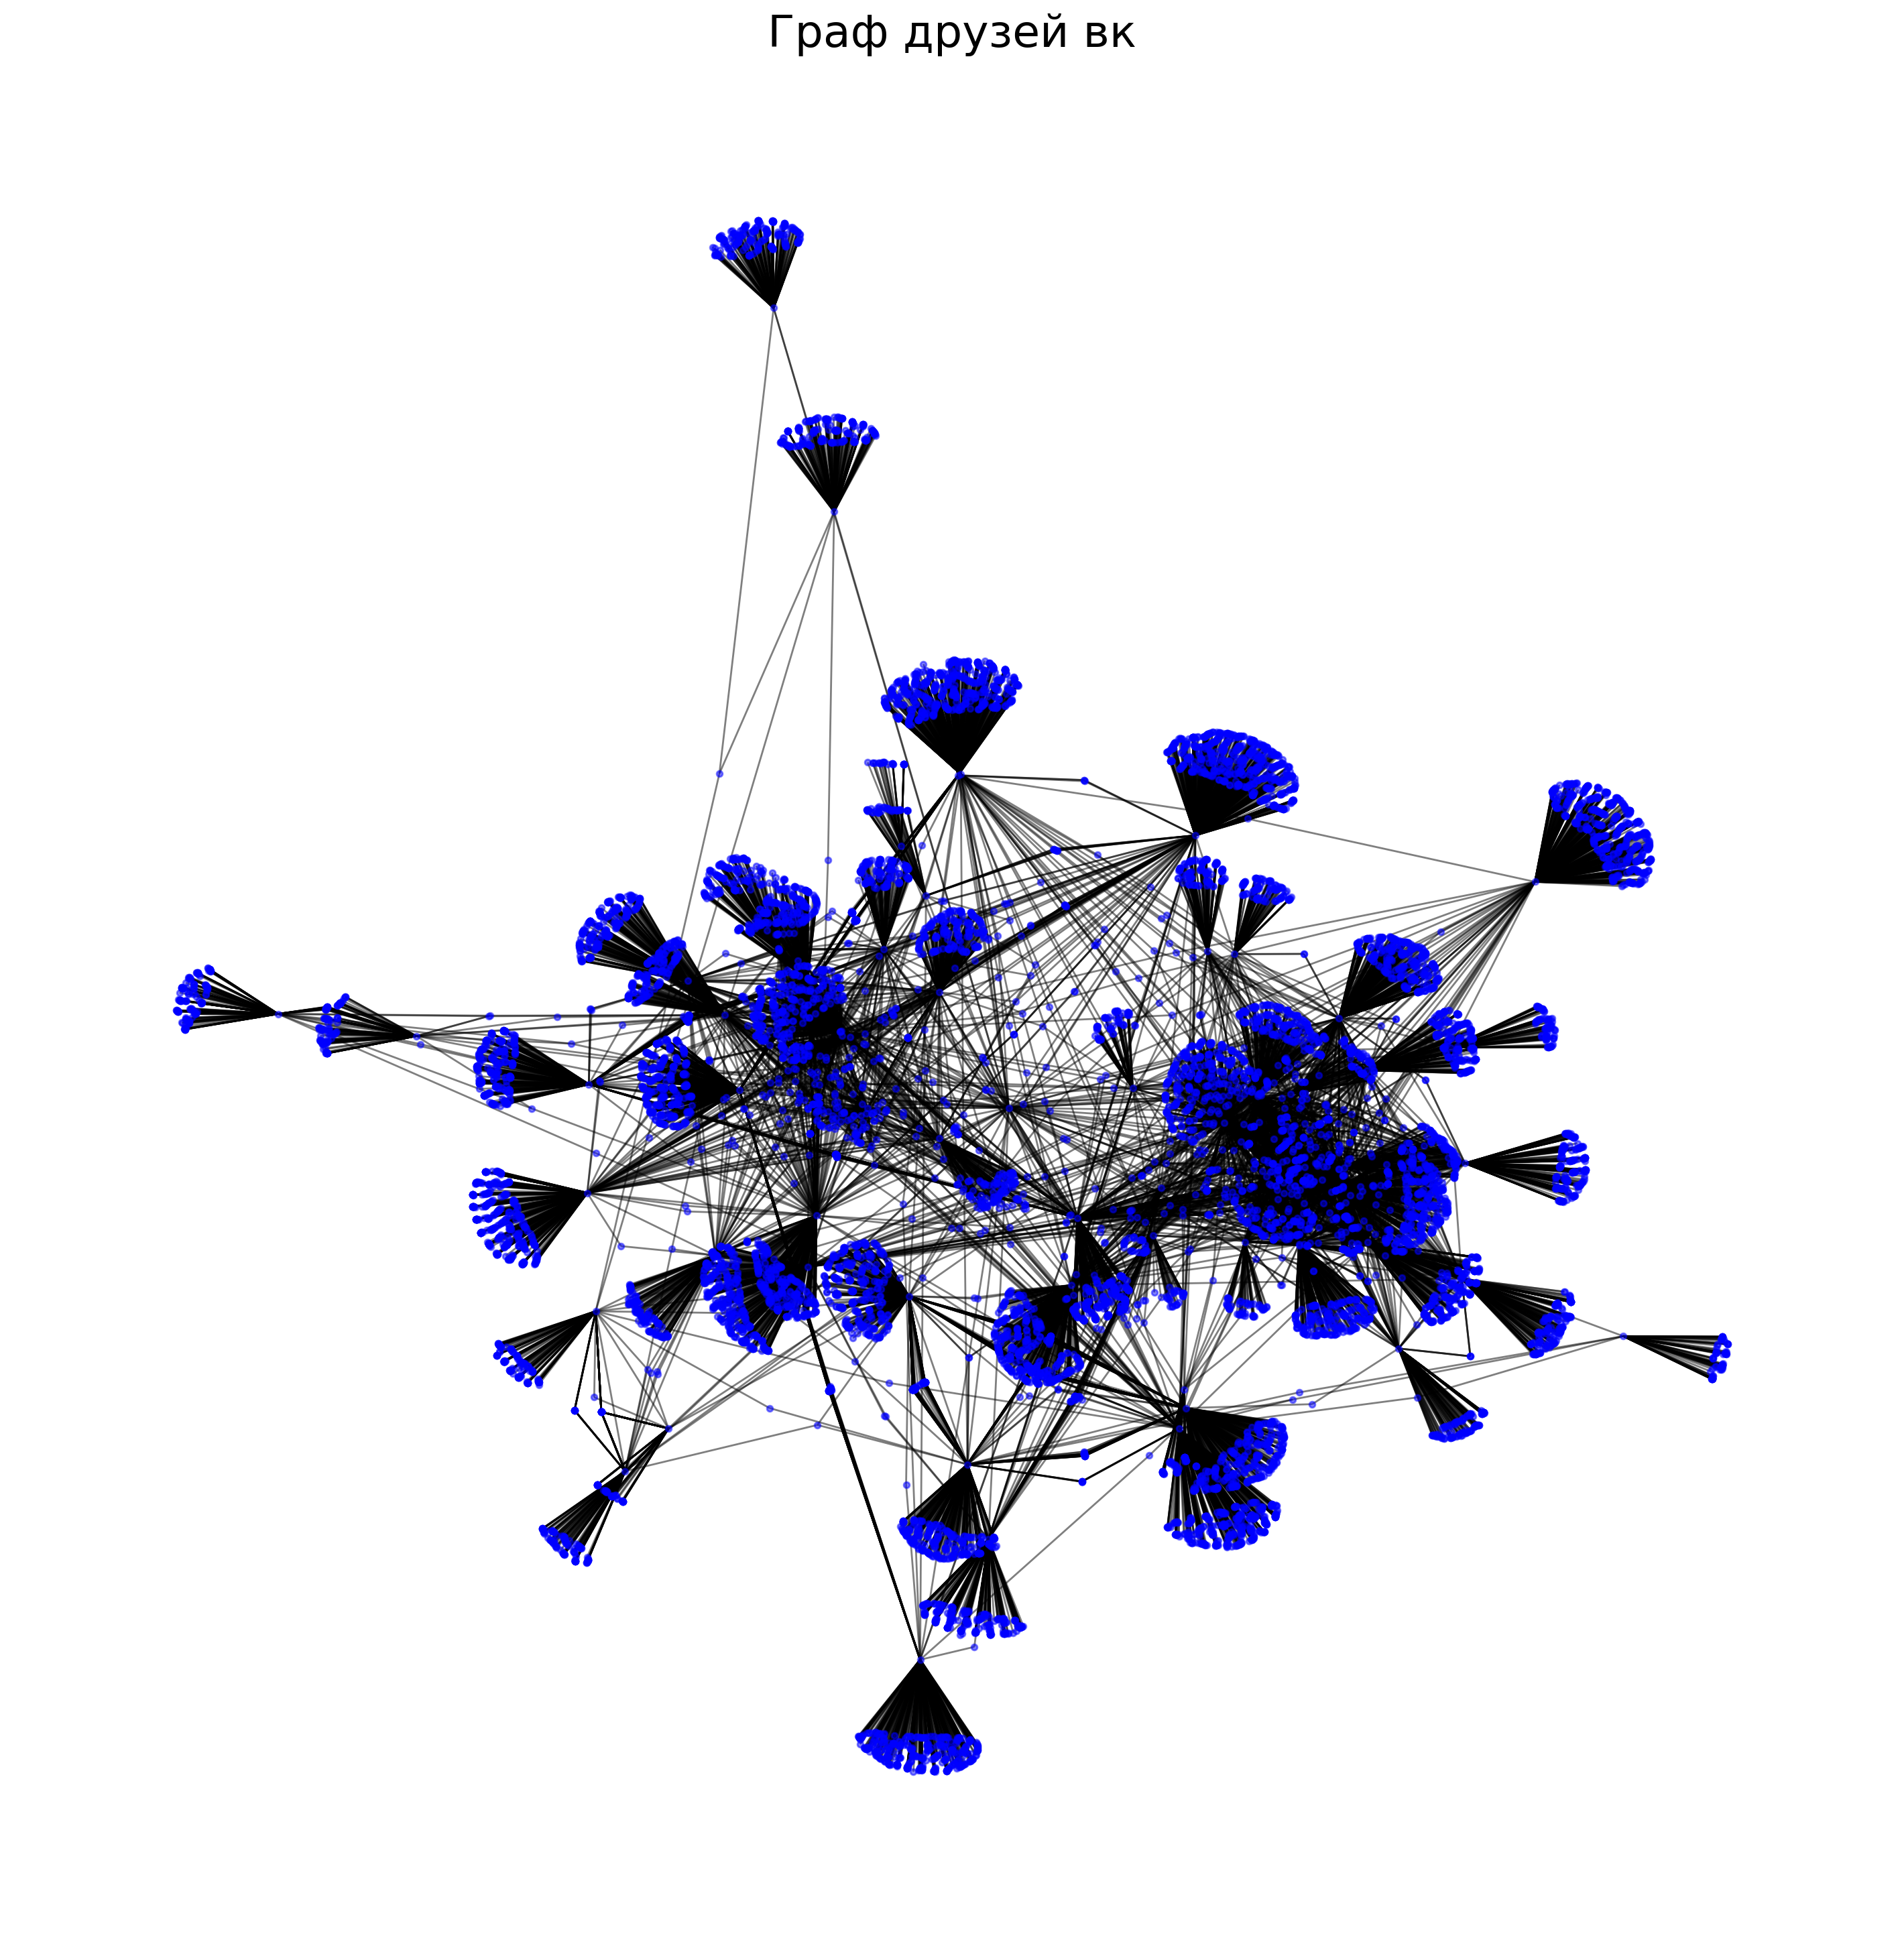

In [136]:
figure(figsize=(14, 14), dpi=200)
nx.draw(G, node_size=10, alpha=0.5, node_color='blue')
plt.title('Граф друзей вк', fontsize=24);

Граф друзей и друзей друзей выглядит логично: в густом облаке я и мои друзья, видно, что у нас наибольшее количество общих друзей. Отдалясь от облака графа можно заметить, что у каждого пользователя свои друзья, лишь небольшая часть которых является общими для других пользователей, поэтому на графе можно наблюдать соответсвующие "гроздья".

# 2. Сравнить граф соавторств ИТИСа, ваш эгоцентрический граф и модельный граф Барабаси-Альберта (с таким же количеством вершин, из домашнего задания 1):
    - распределение степеней вершин в log-log шкале
    - среднюю длину пути между вершинами внутри GCC
    - величину экспоненты $\lambda$:
    
$$P(k) \propto k^{-\lambda}$$

In [200]:
def log_scale_coef(adjacency_matrix,
                   bins_num=20,
                   title=''):
    
    bins = np.histogram(adjacency_matrix.sum(axis=1), bins=bins_num)
    
    # чтобы в логарифм не попадали нули
    nonzero_mask = bins[0]>0
    
    start_linspace = np.min(np.log(bins[1][1:][nonzero_mask]))
    end_linspace = np.max(np.log(bins[1][1:][nonzero_mask]))
    
    model = LinearRegression()
    model.fit(np.log(bins[1][1:][nonzero_mask]).reshape(-1,1), np.log(bins[0][nonzero_mask]))
    x = np.linspace(start_linspace, end_linspace, 100).reshape(-1,1)
    y = model.predict(x)

    figure(figsize=(7, 7), dpi=100)
    
    plt.scatter(np.log(bins[1][1:][nonzero_mask]), np.log(bins[0][nonzero_mask]))
    plt.plot(np.log(bins[1][1:][nonzero_mask]), np.log(bins[0][nonzero_mask]), 
             label='степени вершин log-log scale')

    plt.plot(x, y, c='r', label=f'$\lambda$ = {np.round(model.coef_[0], 3)}')
    plt.legend();
    plt.title(title)
    
    return model, np.log(bins[1][1:][nonzero_mask]).reshape(-1,1), np.log(bins[0][nonzero_mask])

def get_gcc(G):
    connected_components = sorted(nx.connected_components(G), key=len, reverse=True)
    gcc = G.subgraph(connected_components[0])
    
    return gcc

def get_average_path_len(G):
    adjacency_matrix = nx.adjacency_matrix(G).todense()
    g = Graph.Weighted_Adjacency(adjacency_matrix, mode=ADJ_MAX, attr='weight')
    
    return g.average_path_length()

def get_gcc_avg_len(G):
    gcc = get_gcc(G)
    
    return get_average_path_len(gcc)

### Анализ графа друзей вк

In [186]:
adjacency_matrix = np.array(nx.adjacency_matrix(G).todense())

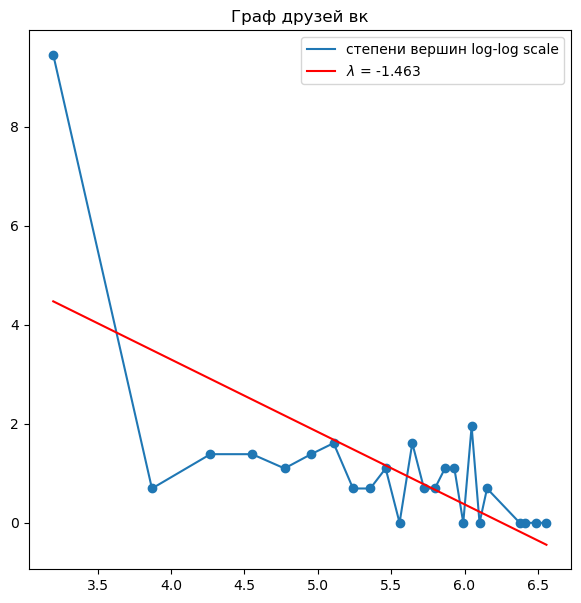

In [ ]:
log_scale_coef(adjacency_matrix,
               bins_num=30,
               title='Граф друзей вк');

In [204]:
print(f'средняя длина пути между вершинами GCC = {get_gcc_avg_len(G)}')

средняя длина пути между вершинами GCC = 3.7857341703600254


### Анализ графа ИТИСа

In [122]:
itas_all = pd.read_excel(ITIS_DATA_PATH)

title_author = itas_all.groupby(by=['title', 'author_id_new']).count().reset_index()
titles, authors = title_author.title, title_author.author_id_new
inc_table = pd.crosstab(authors, titles)
itis_adjacency_matrix = inc_table.values.dot(inc_table.values.T)
n_papers = np.diag(itis_adjacency_matrix)
np.fill_diagonal(itis_adjacency_matrix, 0)
itis_adjacency_matrix[itis_adjacency_matrix>1] = 1

itis_G = nx.from_numpy_array(itis_adjacency_matrix)

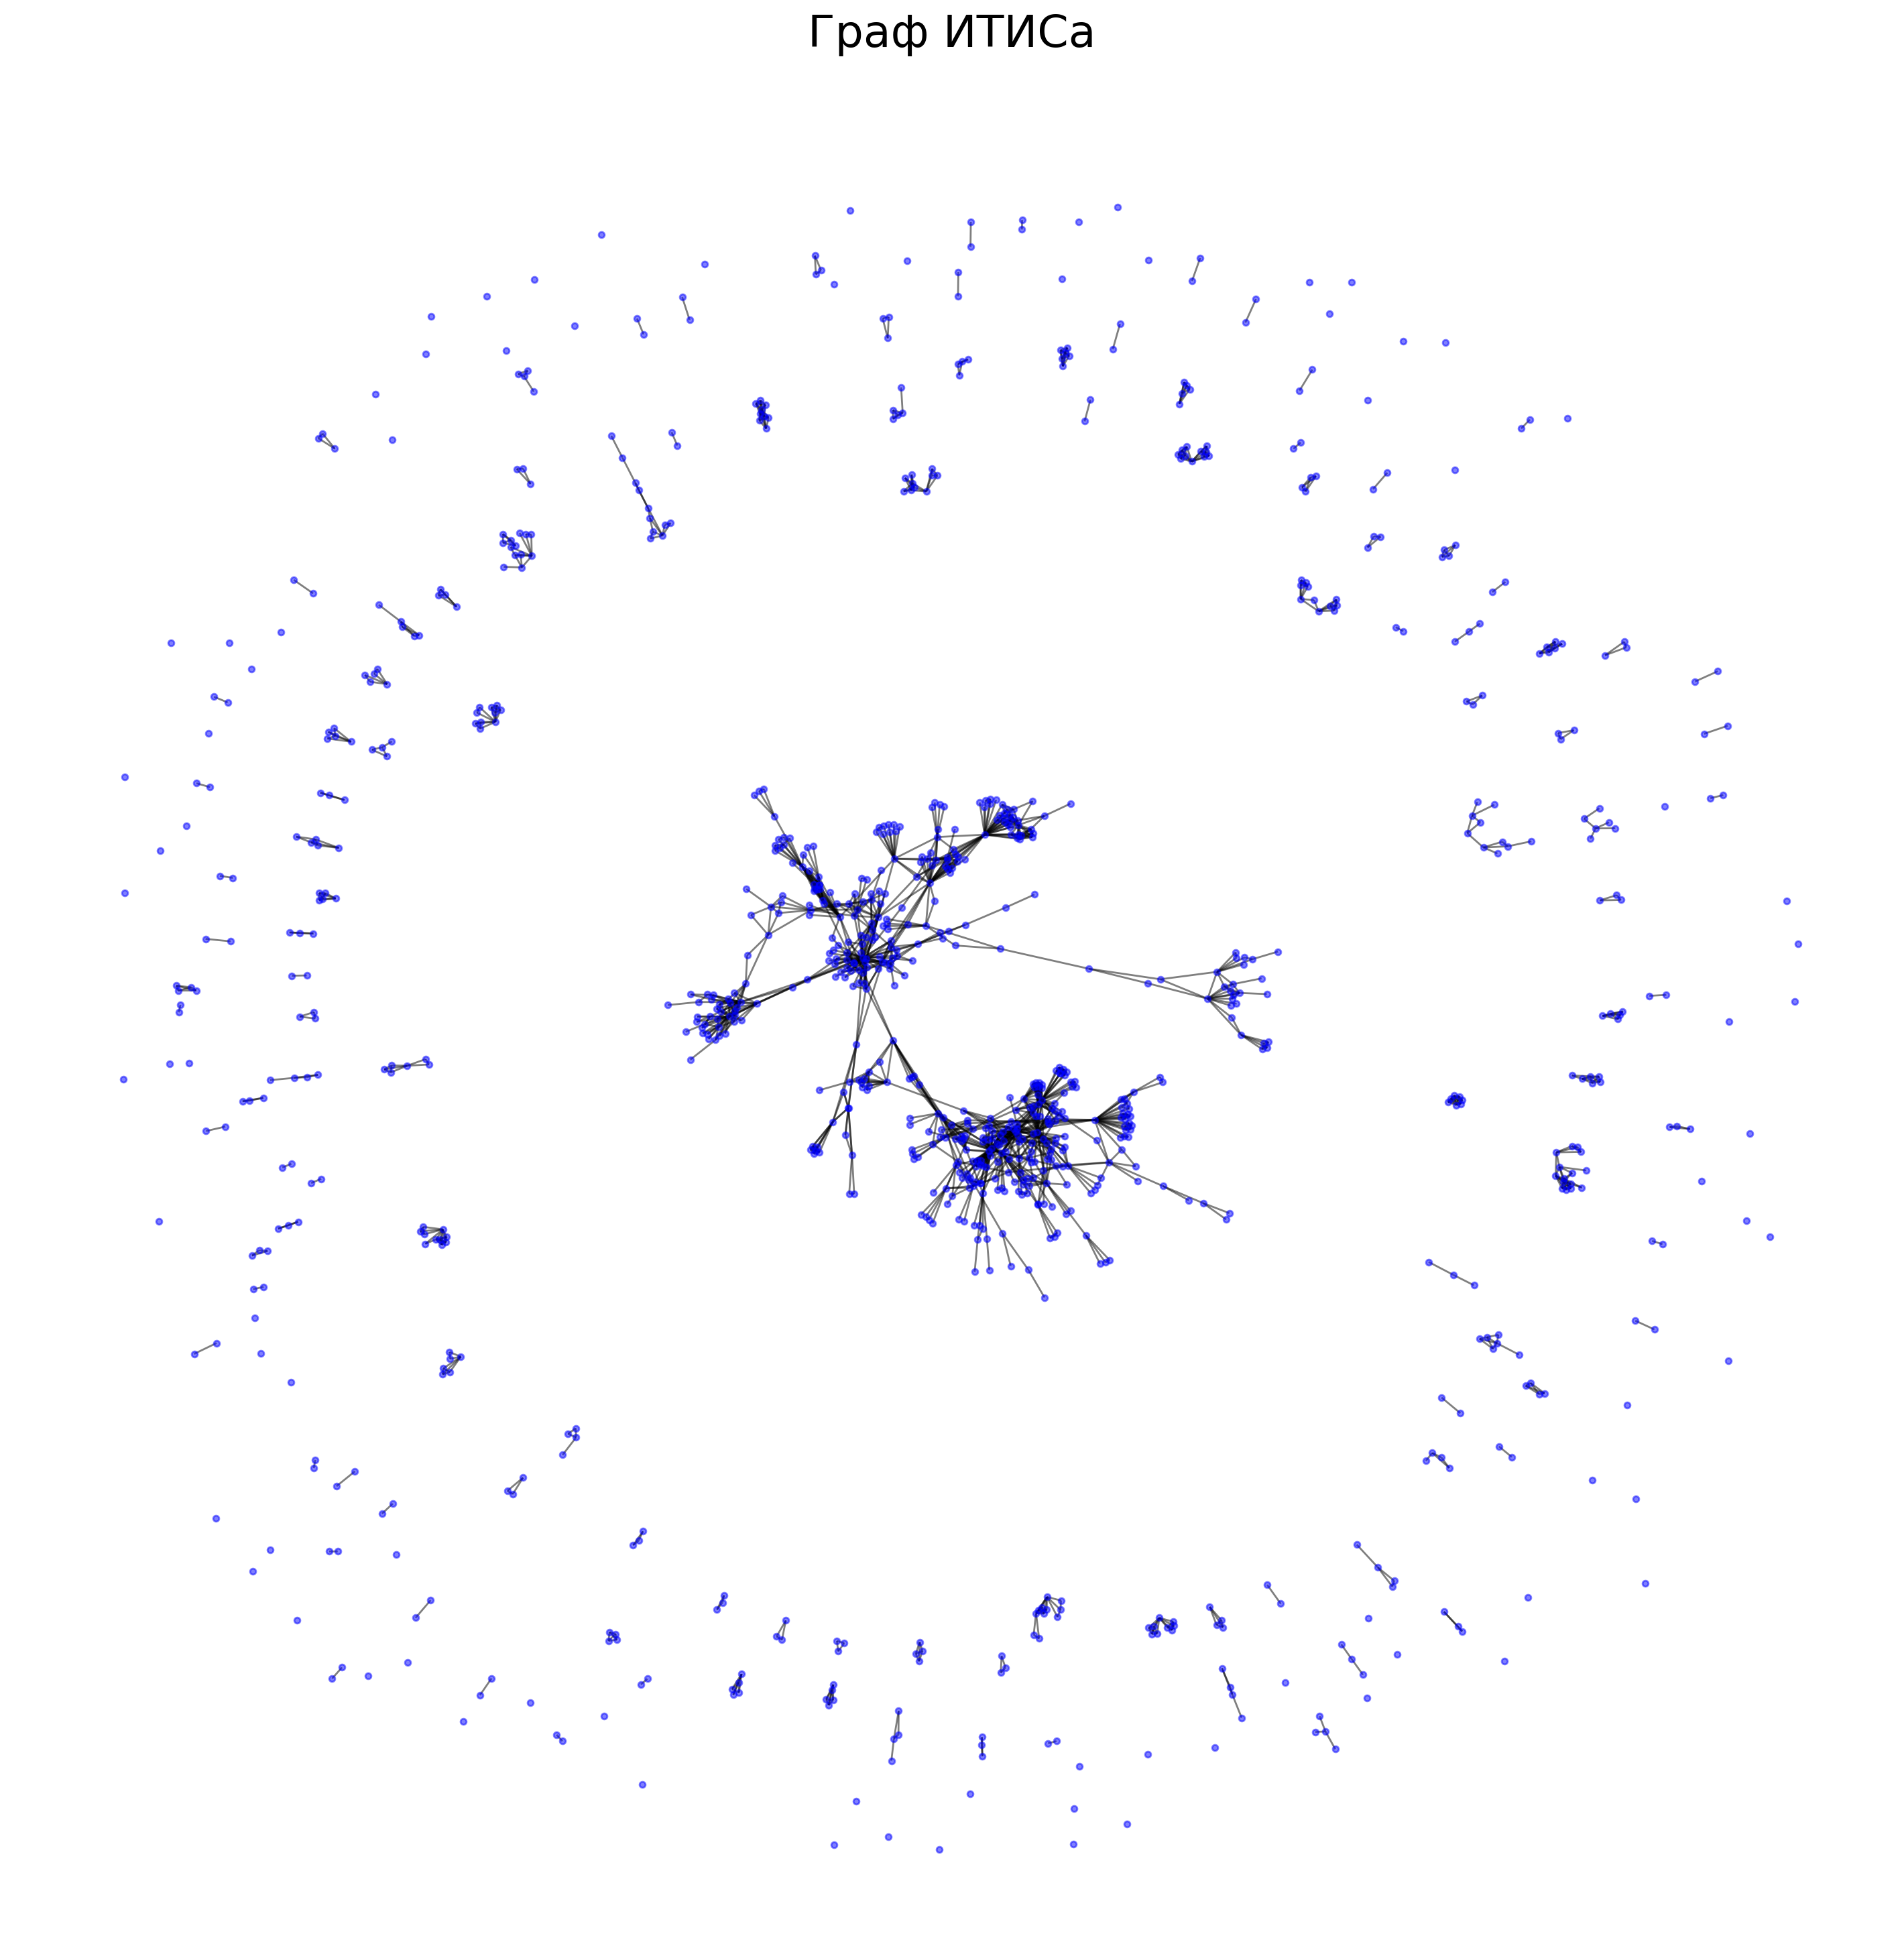

In [123]:
figure(figsize=(14, 14), dpi=200)
nx.draw(itis_G, node_size=10, alpha=0.5, node_color='blue')
plt.title('Граф ИТИСа', fontsize=24);

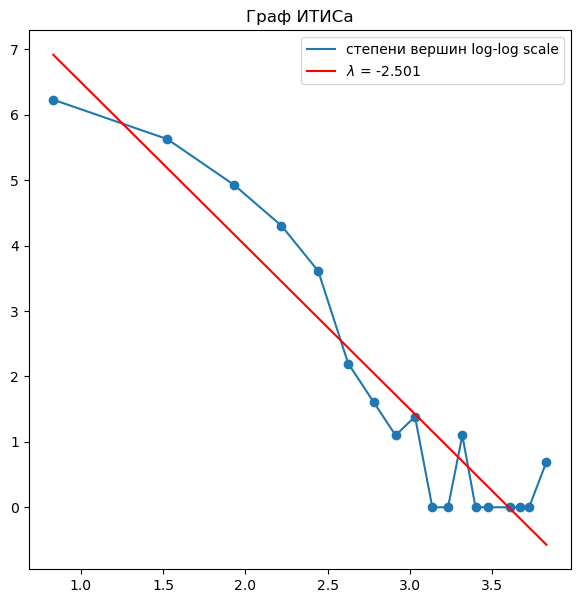

In [175]:
log_scale_coef(itis_adjacency_matrix,
               bins_num=20,
               title='Граф ИТИСа');

In [203]:
print(f'средняя длина пути между вершинами GCC = {get_gcc_avg_len(itis_G)}')

средняя длина пути между вершинами GCC = 6.899122874866575


### Анализ графа барабаси-альберта (с таким же кол-вом вершин как в графе друзей вк)

In [178]:
ba_G = nx.barabasi_albert_graph(n=G.number_of_nodes(), 
                                m=6)

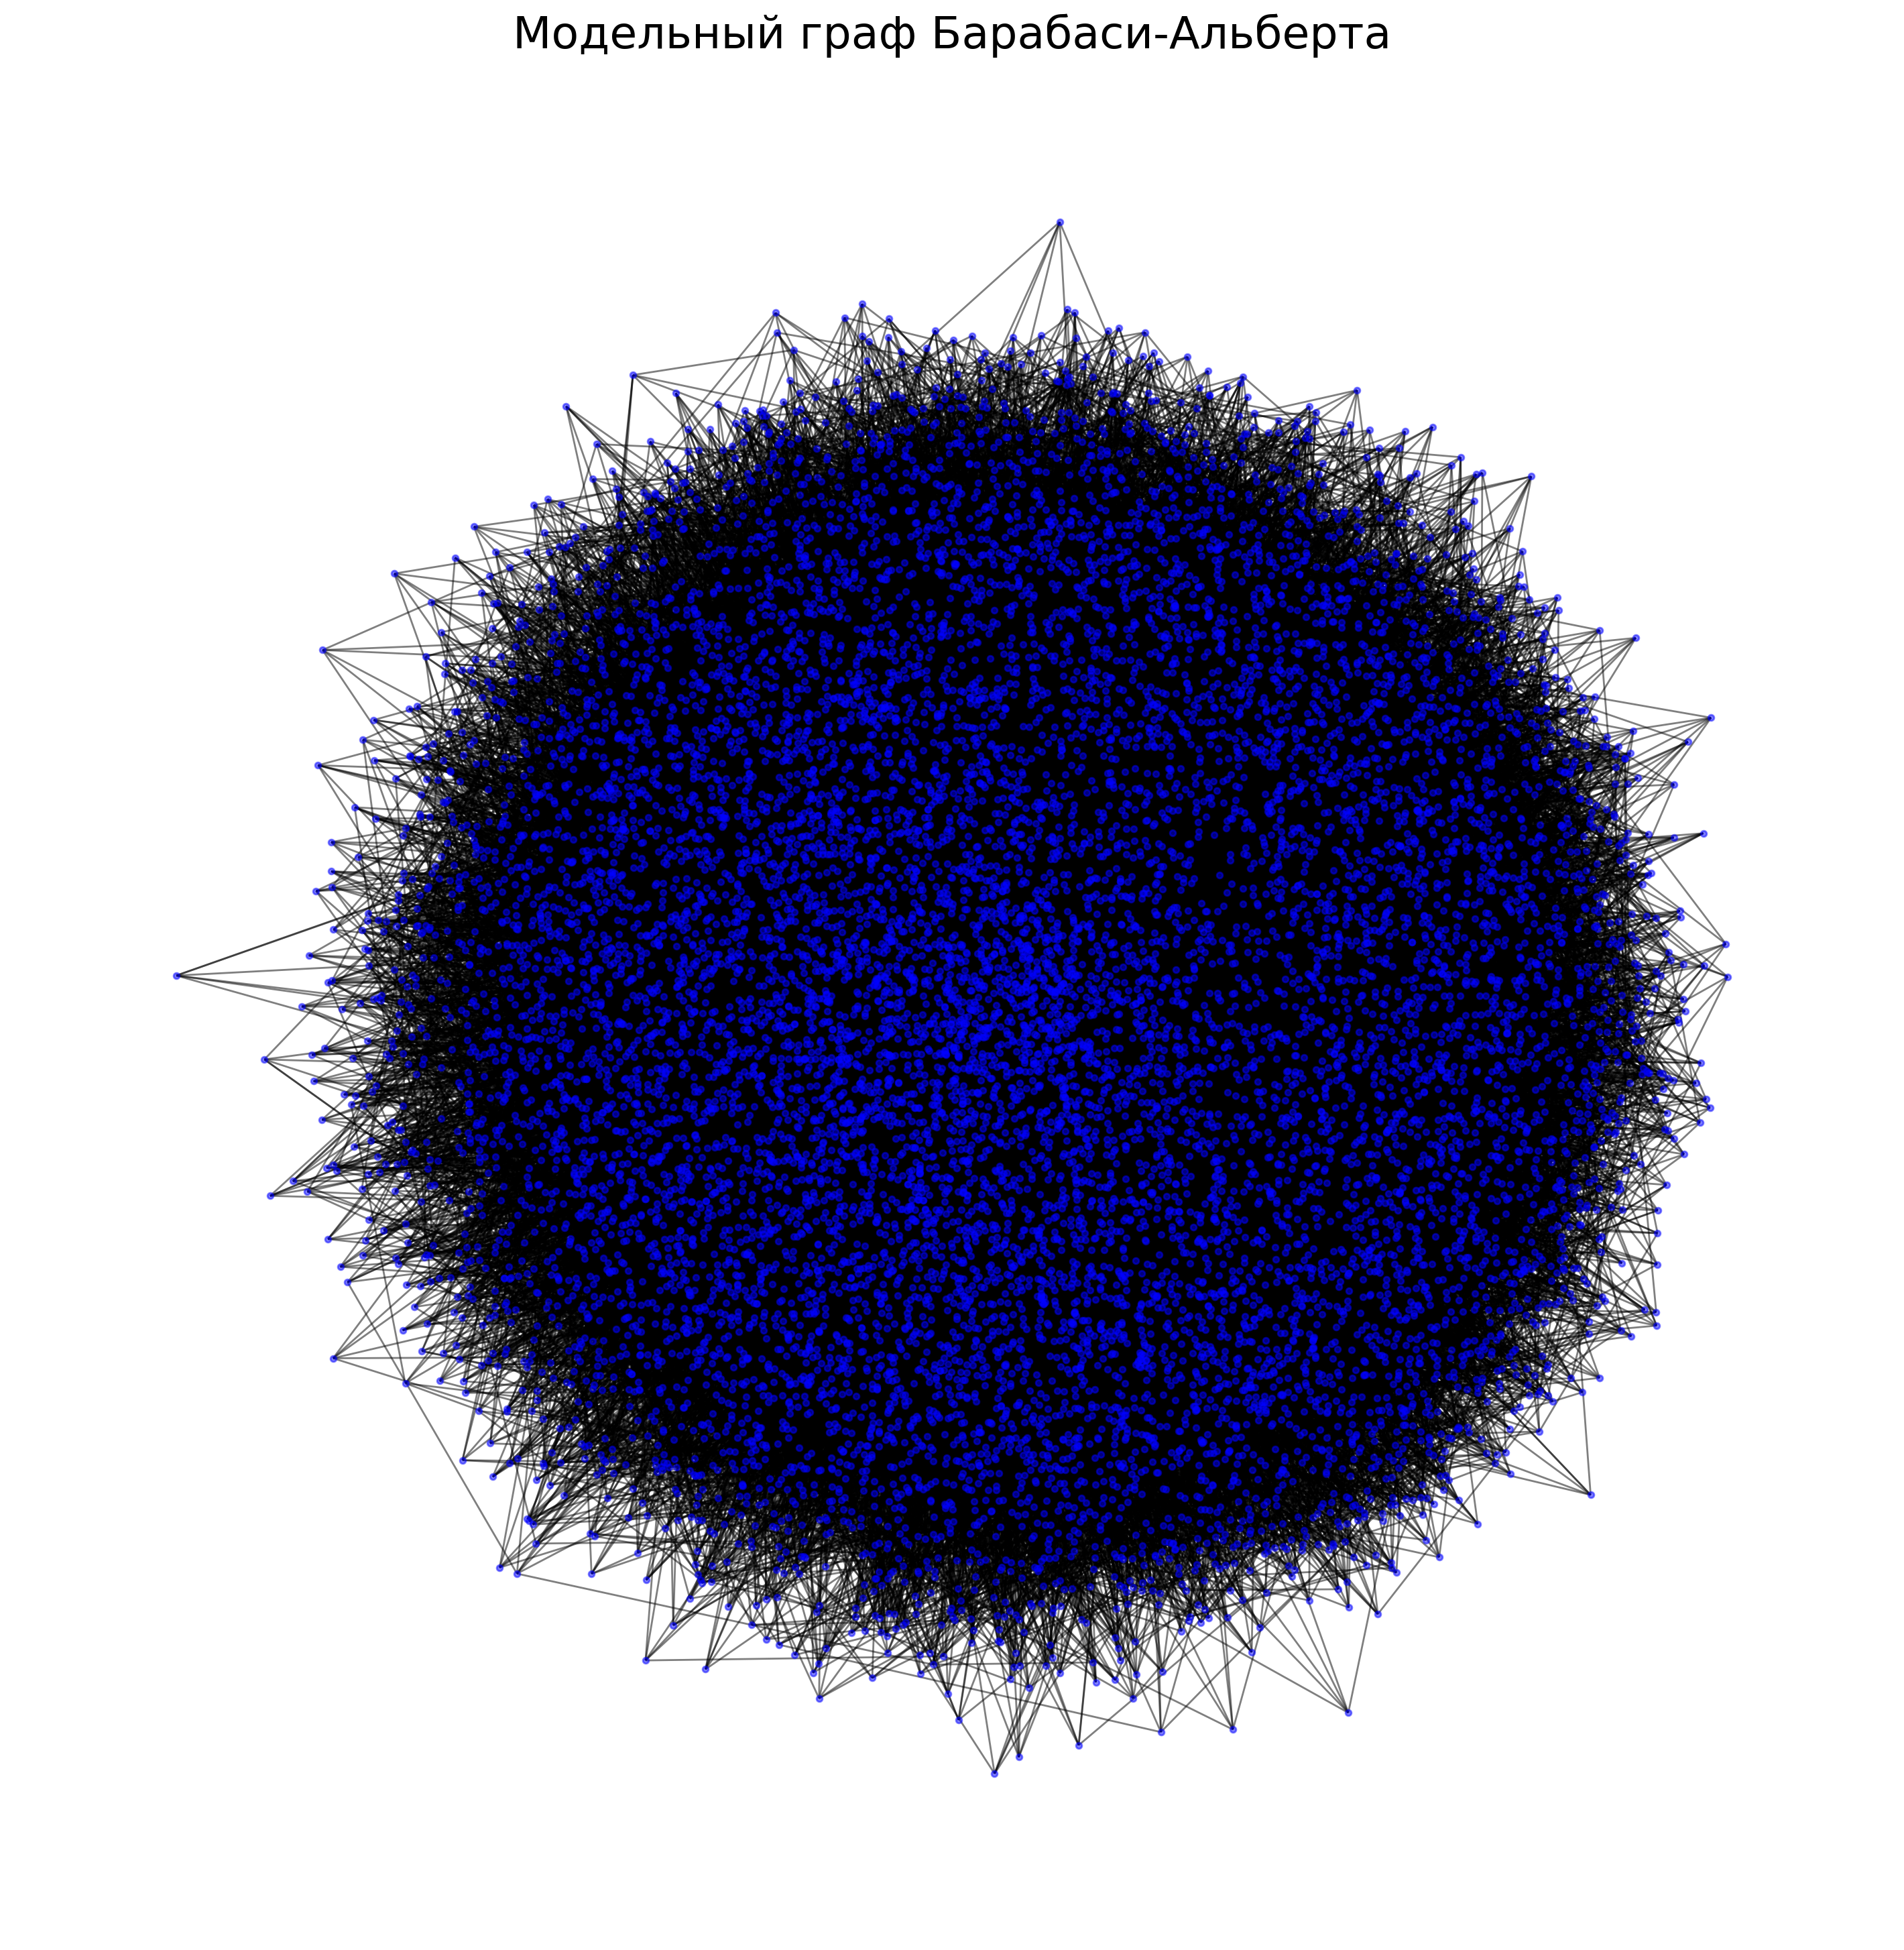

In [182]:
figure(figsize=(14, 14), dpi=200)
nx.draw(ba_G, node_size=10, alpha=0.5, node_color='blue')
plt.title('Модельный граф Барабаси-Альберта', fontsize=24);

In [180]:
ba_adjacency_matrix = np.array(nx.adjacency_matrix(ba_G).todense())

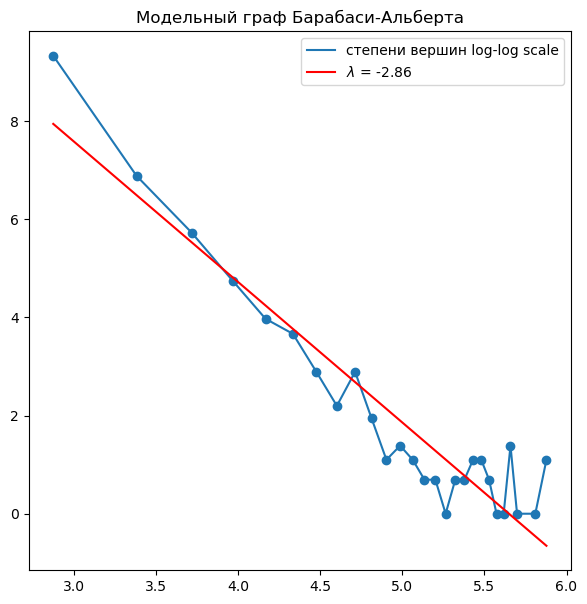

In [181]:
log_scale_coef(ba_adjacency_matrix,
               bins_num=30,
               title='Модельный граф Барабаси-Альберта');

In [205]:
print(f'средняя длина пути между вершинами GCC = {get_gcc_avg_len(ba_G)}')

средняя длина пути между вершинами GCC = 3.5642659179407814


### Сравнительная таблица

| Граф | $\lambda$ | средняя длина пути в gcc |
| --- | --- | --- |
| граф друзей ВК | -1.463 | 3.786 |
| граф ИТИСа | -2.501| 6.899 |
| граф Барабаси-Альберта | -2.86 | 3.564 |

### Вывод:

1. Из трех анализируемых графов модельный граф Барабаси-Альберта наиболее описывается степенным законом $P(k) \propto k^{-\lambda}$. Наименее точно степенным законом описывается граф друзей ВК. Что логично, тк в графе Барабаси-Альберта большая часть узлов попадает в gcc и граф выглядит как одна gcc. В свою очередь, граф друзей ВК скорее состоит из нескольких небольших компонент связности. 

2. Наибольшая средняя длина пути в gcc у графа ИТИСа. Средняя длина пути в gcc в графе друзей ВК и графе Барабаси-Альберта gcc меньше, поэтому gcc выглядит более "концентрированно". 

3. Наибольший по модулю коэффициент $\lambda$ у графа Барабаси-Альберта, у этого графа значения степеней вершин сконцентрированны слева, в области небольших степеней. Граф ИТИСа в этом плане близок к графу Барабаси-Альберта. У графа друзей ВК наибольшее количество узлов с маленькой степенью (где-то 1), остальные узлы распределелись приблизительно равномерно среди оставшихся степеней.